In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [730]:
from pathlib import Path
from dataclasses import asdict
import os
import re
import json
import cProfile
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import wordcloud
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as geopd
import ray
import libpysal
import scipy.sparse
from sklearn.preprocessing import StandardScaler

import src.data.clustering as data_clustering
import src.data.word_counts as word_counts
import src.utils.dist_to_sim as dist_to_sim
import src.utils.paths as paths_utils
import src.utils.parallel as parallel
import src.visualization.maps as map_viz
import src.visualization.interactive as interact_viz
from src.dialects import Region, Language
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
plt.style.reload_library()
plt.style.use(['paper', 'paper_onecol'])

In [3]:
paths = paths_utils.ProjectPaths()
all_cntr_shapes = geopd.read_file(paths.ext_data / 'CNTR_RG_01M_2016_4326.shp' / 'CNTR_RG_01M_2016_4326.shp')

In [4]:
list_langs = []

In [454]:
len(list_langs)

3

0: all fr countries, 1: only FR with parameters below, 2: only FR with parameters 2 cells below, 3: same as 2 but using polar

In [344]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)

lc = 'fr'
list_cc = ['FR'] # [key for key, value in countries_dict.items() if lc in value['local_langs']]
lang = Language.from_countries_dict(
    lc, 'French', list_cc, countries_dict, all_cntr_shapes,
    year_from=2015, year_to=2021, month_from=1, month_to=12,
    min_nr_cells=1, cell_tokens_th=1e5, max_word_rank=None,
    smallest_cell_min_count=5,
    # max_word_rank=int(1e4),
    upper_th=0.4
)
list_langs.append(lang)

In [370]:
lang = Language(
    lc, 'French', list_cc, list_langs[-1].regions, all_cntr_shapes,
    year_from=2015, year_to=2021, month_from=1, month_to=12,
    min_nr_cells=1, cell_tokens_th=5e5, max_word_rank=None,
    smallest_cell_min_count=10,
    # max_word_rank=int(1e4),
    upper_th=0.4
)
list_langs.append(lang)

In [ ]:
lang.cells_geodf['cc'] = lang.cells_geodf.index.str.extract('([A-Z]{2}).+')[0].values
lang.cells_geodf.groupby('cc')['token_sum'].max()

In [455]:
lang.cell_tokens_th = 5e5
lang.smallest_cell_min_count = 10

# Data loading

min_nr_cells in function of min_nr_cells_reg, to calculate on raw_cell_counts index?

In [ ]:
lang.cleanup(include_global=True)

## Global

In [ ]:
lang.global_counts

In [457]:
lang.global_counts = None

In [458]:
global_counts = lang.get_global_counts()

  0%|          | 0/13 [00:00<?, ?it/s]

In [363]:
lang.global_counts.head(20)

,count,is_proper,nr_cells
word,,,
de,48104083.0,0.0,1910.659356
la,30264945.0,0.0,1909.211037
est,29471290.0,0.0,1904.214246
le,26725117.0,0.0,1905.577297
je,24467287.0,0.0,1902.653273
et,22493376.0,0.0,1906.158561
à,22072388.0,0.0,1911.353678
pas,21795995.0,0.0,1902.180371
les,21714574.0,0.0,1908.194851


In [ ]:
lang.global_counts['count'].sum()

## Cell counts

In [459]:
lang.raw_cell_counts = None

In [460]:
raw_cell_counts = lang.get_raw_cell_counts()

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
raw_cell_counts.head()

In [461]:
_ = lang.filter_global_counts()
lang.make_cell_counts_mask()
# can be smaller than what's printed in `make_cell_counts_mask` above if proper noun and
# min_nr_cells masks are active
lang.global_counts['cell_counts_mask'].sum()

Keeping 37345 words.


15911

In [462]:
lang.cell_counts = None

In [463]:
cell_counts = lang.get_cell_counts()

Keeping 386 cells out of 2012 with threshold 5.00e+05.
We had 1687674763 tokens, and filtering  brought it down to 1411918197, so we lost  16.3%.


In [ ]:
cell_counts.head()

## Word metric matrix

TODO: impose large enough cell_tokens_th, and select the union of the sets by cell of words with a proportion superior to k (>1) * 1 / cell_tokens_th. So in the smallest cell, equivalent to having raw count of >~k, so k can be 5, 10. This way you don't exclude very specific words present in only one cell, which is especially an issue when you have whole-country-cells. Then you calculate a z-score, and hence these very specific words will have relatively very high score in those cells 

Set word_tokens_th = k to prefilter

In [464]:
lang.word_counts_vectors = None

In [465]:
word_counts_vectors = lang.get_word_counts_vectors(
    word_mask_col='cell_counts_mask',
    # presence_th=2, nr_tokens_bw=1e6,# smooth_wdist_fun=smooth.power_law#, smooth_wdist_fun=lambda d, **kwargs: np.ones_like(d)
)

0 cells were not found in cell_counts.
0 words were not found in cell_counts.


In [466]:
word_counts_vectors.shape

(386, 15911)

In [467]:
lang.word_vectors = None

In [468]:
# ray.init(num_cpus=8, ignore_reinit_error=True)
_ = lang.get_word_vectors(
    word_vec_var='polar',
    # word_vec_var='Gi_star', spatial_weights_class=libpysal.weights.KNN,
    # spatial_weights_kwargs={'k': 10}
)
lang.word_vectors = lang.word_vectors.filter(lang)
# ray.shutdown()

In [469]:
lang.word_vectors.shape

(386, 15911)

Text(0, 0.5, 'number of words')

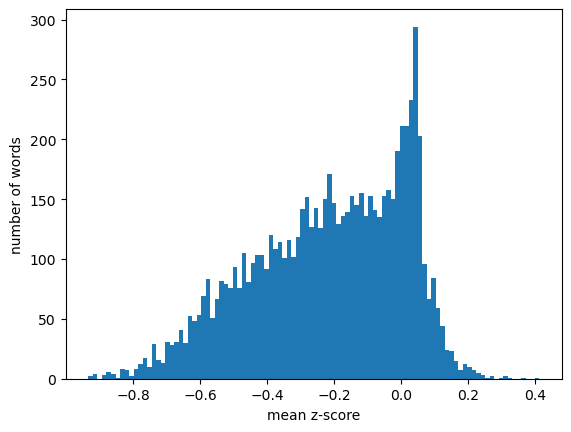

In [19]:
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(lang.word_vectors.mean(axis=0), bins=100)
ax.set_xlabel('mean z-score')
ax.set_ylabel('number of words')

In [ ]:
fig, ax = plt.subplots(1)
_, _, patches = ax.hist(lang.word_vectors.var(axis=0), bins=100)

In [ ]:
lang.global_counts.head()

In [ ]:
lang.map_word('gamin')

# PCA

filter out words  which are not present in some cells just because of their position in tail.
eg word used in only one cell but in high proportion shouldn't be filterd out, bc not in tail in that cell. hence take max prop over all cells? keep only those whose max is k > 1 times superior to 1/cell_tokens_th

## Variance analysis

In [ ]:
is_regional = ((lang.global_counts['z_value'] > 0) #decomp.z_th)
               & (lang.global_counts['p_value'] < 1))#decomp.p_th))
tail_mask = lang.global_counts['tail_mask']
mask = is_regional.loc[tail_mask].values
cells_nr_samples = lang.word_counts_vectors[:, mask].sum(axis=1)

In [ ]:
global_distrib = lang.global_counts.loc[is_regional & tail_mask, 'count']
global_distrib /= global_distrib.sum()
global_cdf = global_distrib.cumsum().values

### Random draw

what about drawing from multinomial?

In [ ]:
rng = np.random.default_rng()

In [ ]:
rand_word_counts = np.zeros_like(lang.word_counts_vectors[:, mask])
for i in range(len(cells_nr_samples)):
    rand_word_counts[i, :] = rng.multinomial(cells_nr_samples[i], global_distrib.values)

In [ ]:
rand_word_counts = np.zeros_like(lang.word_counts_vectors[:, mask])
for i in range(len(cells_nr_samples)):
    draw = rng.random(int(cells_nr_samples[i]))
    assignment = np.searchsorted(global_cdf, draw)
    idc, counts = np.unique(assignment, return_counts=True)
    rand_word_counts[i, idc] = counts

In [ ]:
rand_word_vecs = word_counts.vec_to_metric(
    rand_word_counts, lang.global_counts.loc[tail_mask & is_regional],
    word_vec_var=lang.word_vec_var)

In [ ]:
total_var = lang.word_vectors.var(axis=0).sum()
noise_comp = rand_word_vecs.var(axis=0).sum()
var_to_explain = (total_var - noise_comp) / total_var
var_to_explain

### In mean field

In [ ]:
meanf_word_counts = np.outer(cells_nr_samples, global_distrib)
meanf_word_decpart = meanf_word_counts - meanf_word_counts.astype(int)
inc_idc = np.argsort(-meanf_word_decpart, axis=1)
meanf_word_counts = meanf_word_counts.astype(int)
# Increment by one with what remains of the total per cell, by descending order
# of decimal part
remaining = cells_nr_samples - meanf_word_counts.sum(axis=1)
for i, r in enumerate(remaining):
    meanf_word_counts[i, inc_idc[i, 0:r]] += 1

In [ ]:
meanf_word_vecs = word_counts.vec_to_metric(
    meanf_word_counts, lang.global_counts.loc[tail_mask & is_regional],
    word_vec_var=lang.word_vec_var)

In [ ]:
total_var = lang.word_vectors.var(axis=0).sum()
noise_comp = meanf_word_vecs.var(axis=0).sum()
var_to_explain = (total_var - noise_comp) / total_var
var_to_explain

## Make the decomposition

In [485]:
lang = list_langs[2]

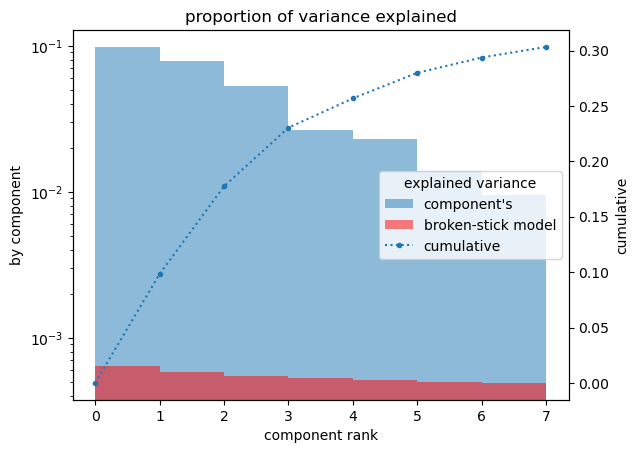

In [800]:
decomp = lang.make_decomposition(n_components=7)#n_components=0.8)
fig, ax = decomp.explained_var_plot(
    lgd_kwargs={'loc': "center right", 'bbox_to_anchor': [1, 0.5]},
    #n_components=10)
)

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:title={'center':'proportion of variance explained'}, xlabel='component rank', ylabel='by component'>)

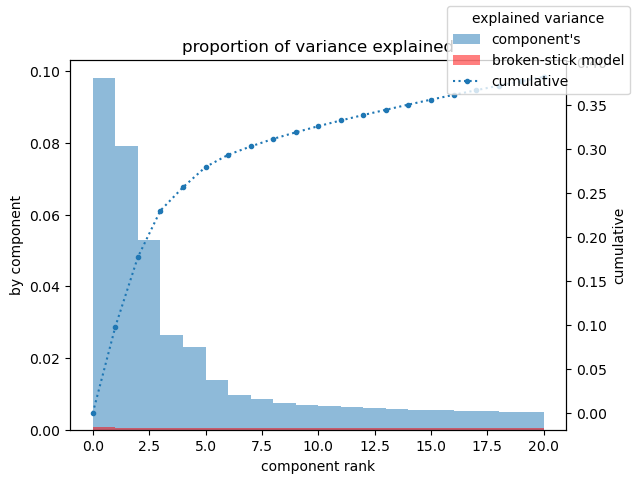

In [799]:
decomp.explained_var_plot(n_components=20, log_scale=False)

In [387]:
decomp = lang.decompositions[-1]
loadings = lang.global_counts.loc[decomp.word_mask].copy()
comps = decomp.decomposition.components_
comp_loadings = pd.DataFrame(
    {f'comp{i_comp}_load': comps[i_comp] for i_comp in range(decomp.n_components)},
    index=loadings.index
)
loadings = pd.concat([loadings, comp_loadings], axis=1)

In [391]:
i_comp = 1
ascending = True
top_loadings = loadings.sort_values(by=f'comp{i_comp}_load', ascending=ascending)#, key=np.abs)
top_loadings.head(20)

,count,is_proper,nr_cells,cell_counts_mask,is_regional,comp0_load,comp1_load,comp2_load,comp3_load,comp4_load,...,comp205_load,comp206_load,comp207_load,comp208_load,comp209_load,comp210_load,comp211_load,comp212_load,comp213_load,comp214_load
word,,,,,,,,,,,,,,,,,,,,,
danserai,262.0,0.0,135.705214,True,True,-0.001909,-0.037784,0.001761,-0.006556,-0.009633,...,0.031223,0.022941,0.021484,-0.017948,0.024673,0.000341,-0.010483,0.030973,-0.008942,0.017351
shinobi,463.0,0.0,167.722025,True,True,0.005196,-0.035444,-0.006257,0.005805,-0.010333,...,-0.003291,-0.011636,0.012890,-0.005263,-0.007396,0.007485,0.011100,-0.027025,0.014371,0.011555
mmmdr,2299.0,0.0,319.114564,True,True,0.000775,-0.034975,0.000476,0.003836,0.003780,...,-0.011771,0.003452,-0.024311,-0.026086,0.006650,0.015289,-0.022028,-0.026093,0.017561,-0.016050
weshhh,1352.0,0.0,332.561397,True,True,0.006810,-0.034779,0.001422,-0.000424,-0.011032,...,-0.004483,-0.007314,0.016441,-0.029405,-0.004064,0.006532,-0.014011,0.002611,0.008475,0.023930
hamdoulilah,5290.0,0.0,522.436289,True,True,0.003295,-0.034586,-0.019307,0.020750,-0.011130,...,0.002217,0.006443,0.001796,-0.018477,-0.006377,0.005693,-0.006078,-0.010948,0.034817,0.010024
zehma,7814.0,0.0,623.700896,True,True,0.001438,-0.034060,-0.015765,0.010728,-0.006171,...,0.002353,0.015459,0.011019,-0.000665,0.009026,0.002421,-0.002155,-0.003902,0.007498,-0.006987
deh,9393.0,0.0,475.250765,True,True,-0.004212,-0.033975,0.008797,0.016403,-0.017221,...,0.005754,0.003419,0.013768,-0.007734,-0.003394,0.004775,-0.003659,-0.011730,-0.009629,0.011236
feelings,542.0,0.0,174.372352,True,True,-0.000286,-0.033269,0.003219,0.010590,-0.018198,...,0.010730,-0.000339,-0.024102,-0.002123,0.009682,0.004502,0.021342,-0.000684,0.035660,0.013973
déboiter,349.0,0.0,174.967201,True,True,-0.002181,-0.033252,0.003448,-0.019189,0.004072,...,-0.009001,0.015866,0.020252,-0.016276,0.005636,0.021820,-0.009363,-0.007570,-0.013834,0.020160


In [ ]:
i_decompo = -1
proj_vectors = lang.decompositions[i_decompo].proj_vectors
i = 0
cbar_label = f'Loading of component {i}'
z_plot = proj_vectors[:, i]
plot_series = pd.Series(z_plot, index=lang.relevant_cells, name='z')
plot_df = lang.cells_geodf.join(plot_series, how='inner')
interact_viz.cells(plot_df, 'z', save_path=Path('lol.html'), show=True)

In [483]:
lang = list_langs[2]

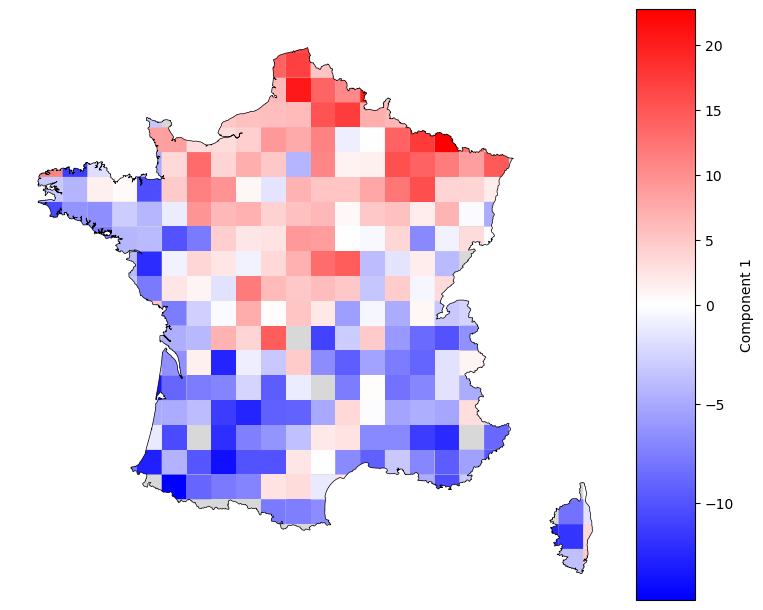

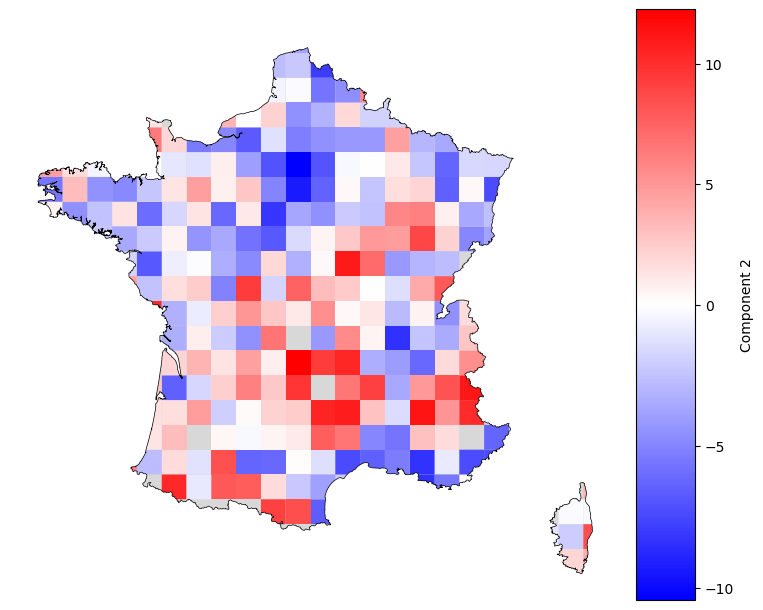

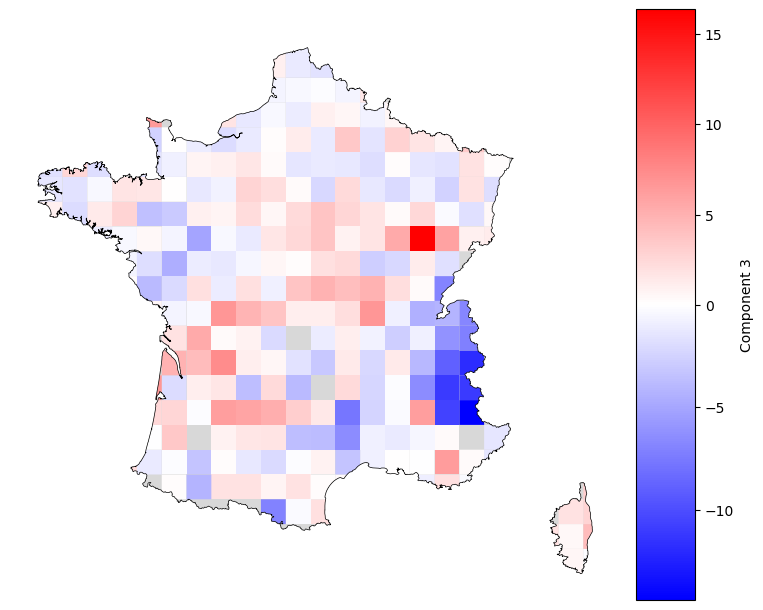

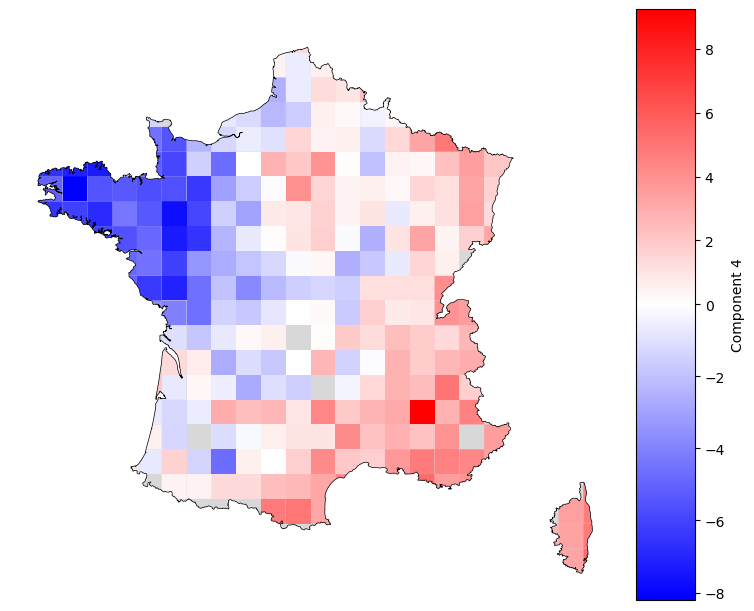

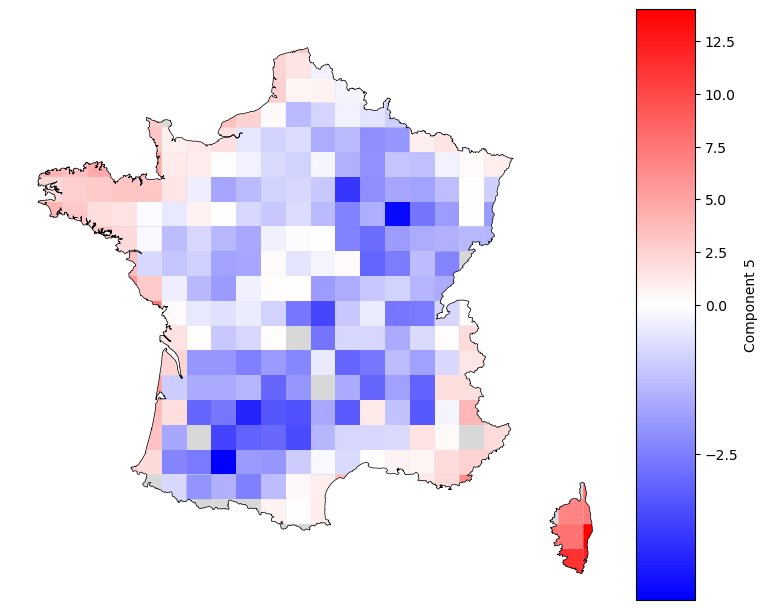

In [484]:
lang.map_comp(
    comps=range(5), i_decompo=-1, total_width=178,
)

In [ ]:
lang.map_comp(comps=[51, 45], i_decompo=-1, total_width=178)

In [ ]:
lang.map_comp(comps=range(2), i_decompo=-2, total_width=178)

In [ ]:
lang.map_comp(comps=range(2), total_width=178)

Gi star

In [ ]:
decomp = lang.decompositions[-1]
proj_vectors = decomp.proj_vectors
plt.scatter(proj_vectors[:, 0], proj_vectors[:, 1], alpha=0.2)

In [ ]:
eng_us.global_counts.head()

In [ ]:
decomp = lang.decompositions[-1]
clust = decomp.clusterings[-1].levels[0]
labels = clust.labels.unique()
mask_clust1 = (clust.labels == labels[0]).values
proj_vectors = decomp.proj_vectors
plt.scatter(proj_vectors[mask_clust1, 0], proj_vectors[mask_clust1, 1],
            alpha=0.2, label=labels[0])
plt.scatter(proj_vectors[~mask_clust1, 0], proj_vectors[~mask_clust1, 1],
            alpha=0.2, label=labels[1])
plt.legend(title='cluster')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.savefig(paths.figs / 'polar_vs_gi' / 'polar_PC_space.pdf')
plt.show()

polar

In [ ]:
decomp = lang.decompositions[1]
clust = decomp.clusterings[0].levels[0]
labels = clust.labels.unique()
mask_clust1 = (clust.labels == labels[0]).values
proj_vectors = decomp.proj_vectors
plt.scatter(proj_vectors[mask_clust1, 0], proj_vectors[mask_clust1, 1],
            alpha=0.2, label=labels[0])
plt.scatter(proj_vectors[~mask_clust1, 0], proj_vectors[~mask_clust1, 1],
            alpha=0.2, label=labels[1])
plt.legend(title='cluster')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.savefig(paths.figs / 'polar_vs_gi' / 'gi_PC_space.pdf')
plt.show()

In [ ]:
eng_us.word_vectors.shape

In [ ]:
lang = eng_all

In [ ]:
proj_vectors = lang.decompositions[-1].proj_vectors
for reg in lang.regions:
    mask = np.where(lang.cells_geodf.loc[lang.relevant_cells].index.str.startswith(reg.cc))[0]
    plt.scatter(proj_vectors[mask, 0], proj_vectors[mask, 1], label=reg.cc, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.savefig(paths.figs / 'polar_vs_gi' / 'nat_countries_gi_PC_space.pdf',
#             bbox_inches='tight')
plt.show()

# Clustering

## Agglo

In [450]:
# agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
max_n_clusters = 9
clustering = lang.decompositions[-1].add_scipy_hierarchy(
    lang.relevant_cells, max_n_clusters=max_n_clusters, **agg_clustering_params
)

In [ ]:
fig, ax = clustering.plot_dendrogram(coloring_lvl=5)

In [ ]:
fig, ax = plt.subplots(1)
ax.plot([1] + [lvl.nr_clusters for lvl in clustering.levels],
        [0] + [lvl.score for lvl in clustering.levels], marker='.', ls='--')

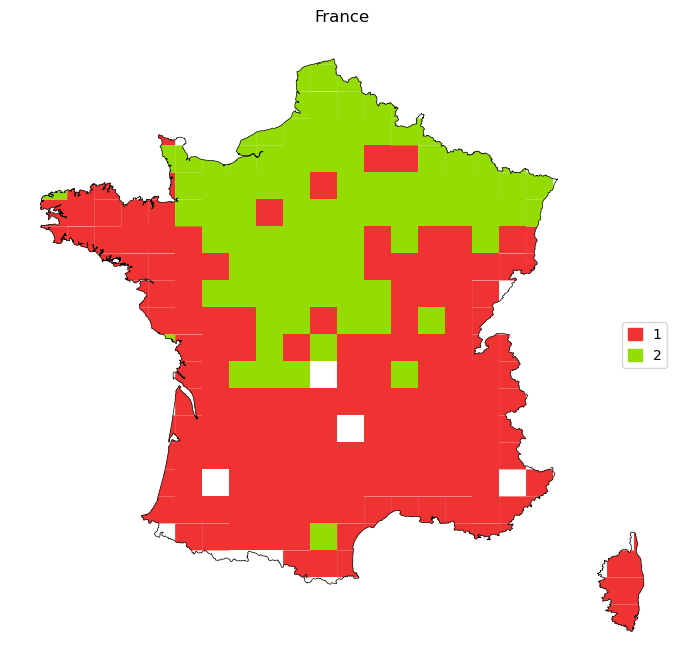

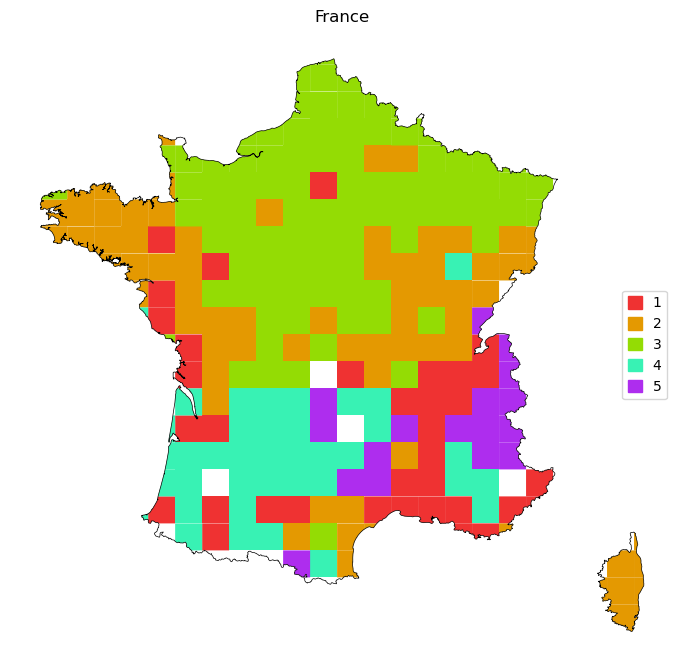

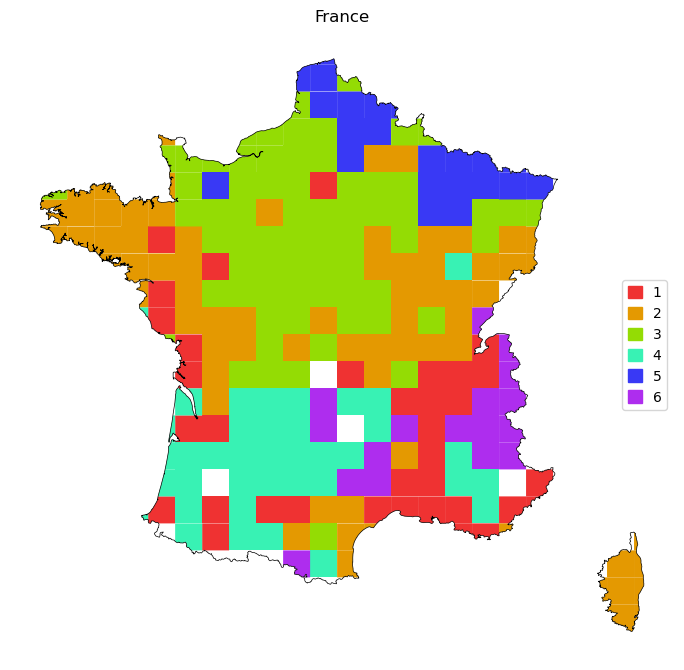

In [451]:
fig, axes = lang.map_clustering(levels_subset=[0, 3, 4])

In [ ]:
fig, axes = lang.map_clustering(levels_subset=[3,4])

In [ ]:
fig, axes = lang.map_clustering()

In [ ]:
lang.silhouette_plot(i_clust=-1)

In [ ]:
# agg_clustering_params = {'metric': 'cosine', 'method': 'average'}
agg_clustering_params = {'metric': 'euclidean', 'method': 'ward'}
linkage = shc.linkage(proj_vectors, **agg_clustering_params)
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linkage, p=30, truncate_mode='lastp')

In [ ]:
max_nr_clusters = 5
nr_clusters_arr = np.asarray(range(2, max_nr_clusters + 1))
cutree = shc.cut_tree(linkage, n_clusters=nr_clusters_arr)

In [ ]:
hierarc_clust = cutree[:, 0]
plt.scatter(proj_vectors[hierarc_clust==0, 0], proj_vectors[hierarc_clust==0, 1], c='b', alpha=0.5)
plt.scatter(proj_vectors[hierarc_clust==1, 0], proj_vectors[hierarc_clust==1, 1], c='g', alpha=0.5)

In [ ]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

In [ ]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

In [ ]:
cmap = 'Dark2'
for i, n_clusters in enumerate(nr_clusters_arr):
    fig, axes = map_viz.joint_cc(
        cells_geodf.loc[relevant_cells], cutree[:, i], data_dict, cmap=cmap, show=True,
        figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

## GMM

In [ ]:
import sklearn.mixture

In [ ]:
kwargs = {'n_components': 3, 'covariance_type': 'full'}
method = sklearn.mixture.BayesianGaussianMixture
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, **kwargs)

In [ ]:
fig, ax = plt.subplots(1)
clusts = lang.decompositions[-1].clusterings[-4:]
ax.plot([0] + [lvl.nr_clusters for lvl in clusts],
        [0] + [lvl.score for lvl in clusts], marker='.', ls='--')

In [ ]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, cmap='Dark2',
#                                save_path_fmt=lang.paths.cluster_fig_fmt
                               )

In [ ]:
fig, ax = clustering.silhouette_plot(lang.decompositions[-1].proj_vectors)

In [ ]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, cmap='Dark2')

In [ ]:
n_components = 5
dpgmm = sklearn.mixture.BayesianGaussianMixture(
    n_components=n_components, covariance_type='full').fit(lang.decompositions[-1].proj_vectors)
dpgmm_res = dpgmm.predict(lang.decompositions[-1].proj_vectors)

In [ ]:
cmap = 'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], dpgmm_res, data_dict, cmap=cmap, show=True,
    figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

In [ ]:
cmap = 'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], dpgmm_res, data_dict, cmap=cmap, show=True,
    figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

In [ ]:
hierarc_clust = dpgmm_res
for i in range(n_components):
    plt.scatter(proj_vectors[hierarc_clust==i, 0], proj_vectors[hierarc_clust==i, 1], alpha=0.5)

## DBSCAN / OPTICS

In [ ]:
opt_params = {'min_samples': 10, 'xi': 0.01, 'min_cluster_size': 5,
              'metric': 'euclidean'}
method = sklearn.cluster.OPTICS
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, append=True, **opt_params)

In [ ]:
fig, ax = clustering.reach_plot()

In [ ]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1)

In [ ]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-2,
                               save_path_fmt=lang.paths.cluster_fig_fmt)

In [ ]:
dbscan_params = {'eps': 4, 'min_samples': 10, 'metric': 'euclidean'}
method = sklearn.cluster.DBSCAN
clustering = lang.decompositions[-1].add_clustering(
    method, lang.relevant_cells, append=False, **dbscan_params)

In [ ]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1,
#                                save_path_fmt=lang.paths.cluster_fig_fmt
                               )

In [ ]:
dbscan_params = {'eps': 3, 'min_samples': 10, 'metric': 'cosine'}
db = sklearn.cluster.DBSCAN(**dbscan_params).fit(proj_vectors)
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(n_clusters, n_noise)

In [ ]:
cmap = None #'Dark2'
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], db.labels_, data_dict, cmap=cmap, show=True,
    figsize=(18,6), gridspec_kw={'width_ratios': width_ratios})

In [ ]:
dbscan_params = {'eps': 0.06, 'min_samples': 3, 'metric': 'cosine'}
db = sklearn.cluster.DBSCAN(**dbscan_params).fit(proj_vectors)
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)
print(n_clusters, n_noise)

In [ ]:
cmap = None
fig, axes = map_viz.joint_cc(
    cells_geodf.loc[relevant_cells], db.labels_, data_dict, cmap=cmap, show=True,
    figsize=(9,3), gridspec_kw={'width_ratios': width_ratios})

## Graph

In [801]:
lang = list_langs[0]
decomp = lang.decompositions[-1]
lang.paths.case_processed.mkdir(parents=True, exist_ok=True)
if not decomp.save_path.exists():
    with open(decomp.save_path, "wb") as f:
        pickle.dump(decomp, f)
print(decomp.word_vectors.word_vec_var, decomp.save_path)

polar /home/thomaslouf/Documents/code/words-use/data/processed/fr/BE-CA-CD-CH-CI-CM-DZ-FR-LB-LU-MA-SN-TN/2015-2021/decomp_word_vec_var=polar_n_components=7.pickle


try removing weakest links see when split from single connected component how the "communities" look like

To try: plot distirb of weights, fit to gaussian and cut at mean - k*sigma

### Oslom

In [258]:
import scipy.spatial.distance

In [300]:
# metric = 'euclidean'
# transfo = None
metric = 'cosine'
transfo = cos_to_exp
oslom_opt_params = ['-singlet', '-r', '50']
decomp = lang.decompositions[-1]

In [297]:
data_path = decomp.prep_oslom(
    metric, lang.paths.net_fmt, transfo=transfo
)
# p = data_clustering.run_oslom(data_path, oslom_opt_params=oslom_opt_params)

In [298]:
data_path

PosixPath('/home/thomaslouf/Documents/code/words-use/data/processed/fr/FR/net_metric=euclidean_scaler=None_transfo=inverse_word_vec_var=z_score_decomposition=PCA-.dat')

In [301]:
decomp.add_oslom_hierarchy(
    metric, lang.paths.net_fmt, lang.relevant_cells, transfo=transfo,
    oslom_opt_params=oslom_opt_params
)

- level 0


HierarchicalClustering(method_repr='oslom', cmap=None, method_args=None, method_kwargs=None, kwargs_str='_metric=cosine_transfo=cos_to_exp-singlet-r50', linkage=None, cut_tree=None)

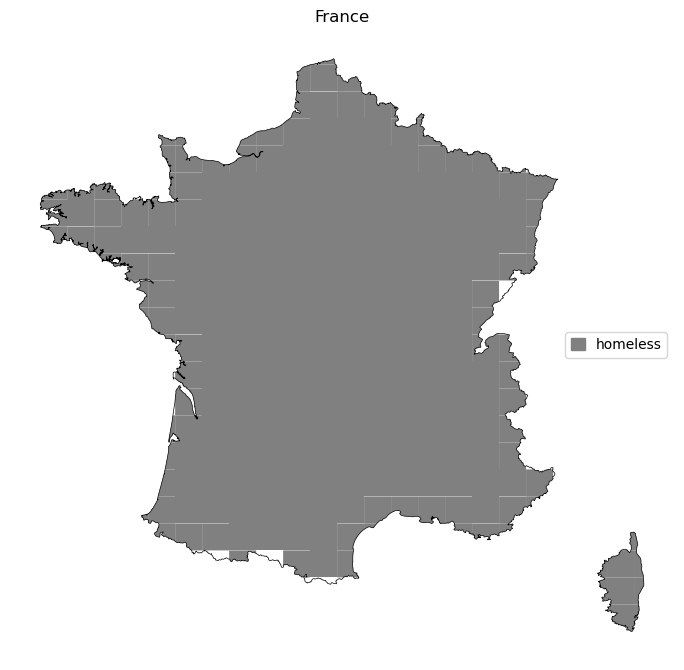

In [302]:
figs, axes = lang.map_clustering(i_clust=-1)#, save_path_fmt=lang.paths.cluster_fig_fmt)

### SBM

In [20]:
import graph_tool.all as gt
import scipy.spatial.distance

In [ ]:
gt.label_components

In [666]:
g = decomp.make_gt_graph(**sbm_kwargs)
edge_sorting = np.argsort(g.ep['weight'].get_array())
sorted_edges = np.asarray(list(g.edges()))[edge_sorting]
sizes, comp = gt.edge_percolation(g, [(e.source(), e.target()) for e in sorted_edges])

In [ ]:
x = scipy.spatial.distance.pdist(decomp.proj_vectors, metric='euclidean')
_ = plt.hist(x, bins=100)

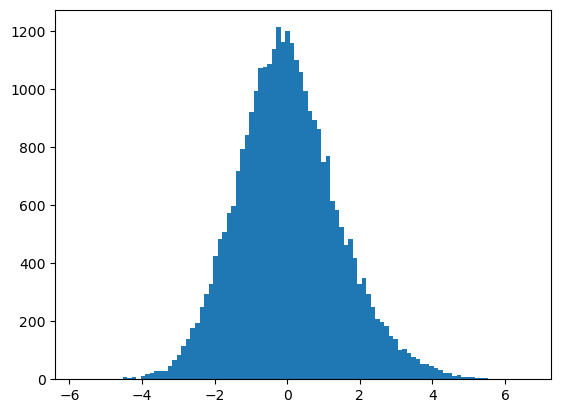

In [490]:
x = arctanh(scipy.spatial.distance.pdist(decomp.proj_vectors, metric='correlation'))
_ = plt.hist(x, bins=100)

Log normal! Even looks forged

In [807]:
sbm_kwargs = {
    'metric': 'cosine',
    'transfo': "cos_to_exp",
    'rec_types': 'real-exponential'
}
sbm_kwargs = {
    'metric': 'correlation',
    'transfo': "arctanh",
    'rec_types': 'real-normal',
    # 'scaler': StandardScaler(),
}
sbm_kwargs = {
    'metric': 'euclidean',
    'transfo': "log_inverse",
    'rec_types': 'real-normal',
    # 'scaler': "StandardScaler",
}

### In nured

In [808]:
args = f'--decomp-save-path {decomp.save_path}'
for k, v in sbm_kwargs.items():
    args += f" --{k.replace('_', '-')} {v}" # .replace('-', '_dash_')
parallel.nured_run('sbm.py', args, time=300)

/usr/local/bin/run -t 300 -o logs/sbm_2023-02-13T11:47:17.424.log -e logs/sbm_2023-02-13T11:47:17.424.log "/home/thomaslouf/miniconda3/envs/words-use/bin/python sbm.py --decomp-save-path /home/thomaslouf/Documents/code/words-use/data/processed/fr/BE-CA-CD-CH-CI-CM-DZ-FR-LB-LU-MA-SN-TN/2015-2021/decomp_word_vec_var=polar_n_components=7.pickle --metric euclidean --transfo log_inverse --rec-types real-normal";
[]
['Submitted batch job 11155658\n']


In [757]:
state = decomp.load_sbm_res(**sbm_kwargs)

EOFError: Ran out of input

### Salmunia with ray

-1 is for 7 comps, -2 is for list_langs[0]

In [ ]:
ray.init(num_cpus=2)
@ray.remote
def remote_run_decomp_sbm(decomp, **sbm_kwargs):
    # Add sbm_kwargs to be able to link the result to a set of params.
    return decomp.run_sbm(**sbm_kwargs), sbm_kwargs
state_refs = []

In [492]:
state_refs.append(remote_run_decomp_sbm.remote(decomp, **sbm_kwargs))

In [ ]:
state, state_sbm_kwargs = ray.get(state_refs[-2])

### Viz result

In [616]:
print(state.entropy())
state.print_summary()

-3605.917006237866
l: 0, N: 386, B: 54
l: 1, N: 54, B: 18
l: 2, N: 18, B: 4
l: 3, N: 4, B: 2
l: 4, N: 2, B: 2
l: 5, N: 2, B: 2
l: 6, N: 2, B: 2
l: 7, N: 2, B: 2
l: 8, N: 2, B: 2
l: 9, N: 2, B: 2


In [603]:
state.levels[1].get_N()

31

In [617]:
decomp.add_sbm_hierarchy(state, lang.relevant_cells, **state_sbm_kwargs)

HierarchicalClustering(method_repr='sbm', cmap=None, method_args=None, method_kwargs=None, kwargs_str='_metric=correlation_transfo=<function arctanh at 0x7f67688f31c0>_covar=real-normal', linkage=None, cut_tree=None)

In [ ]:
res.draw()

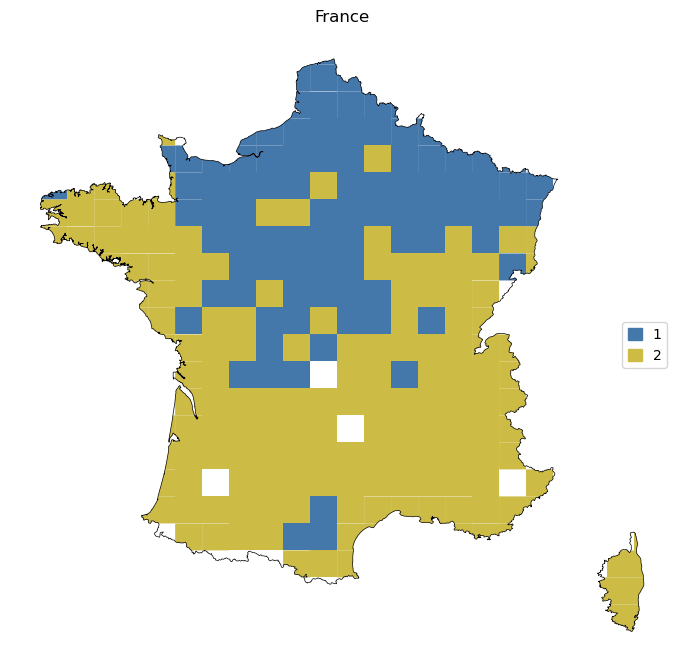

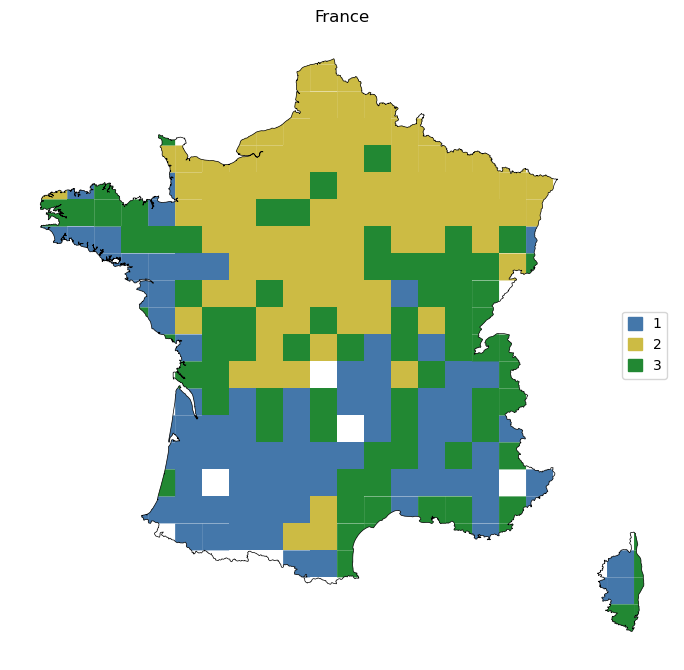

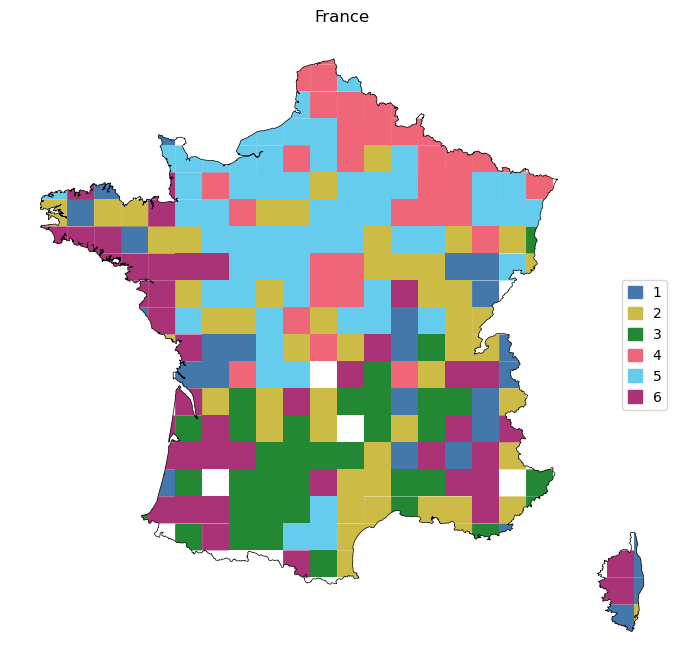

In [613]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, levels_subset=[0,1,2])

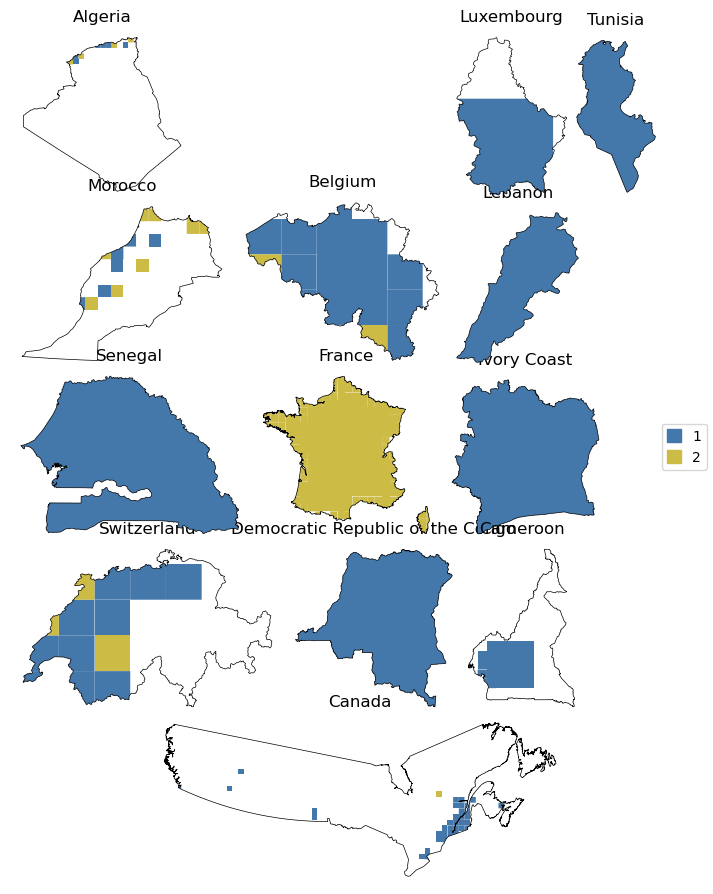

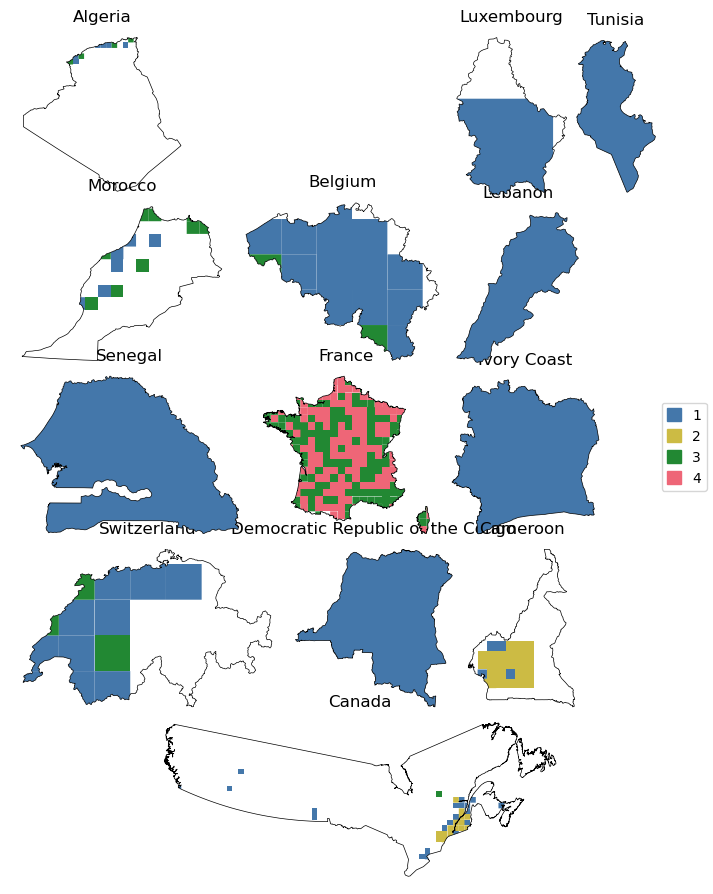

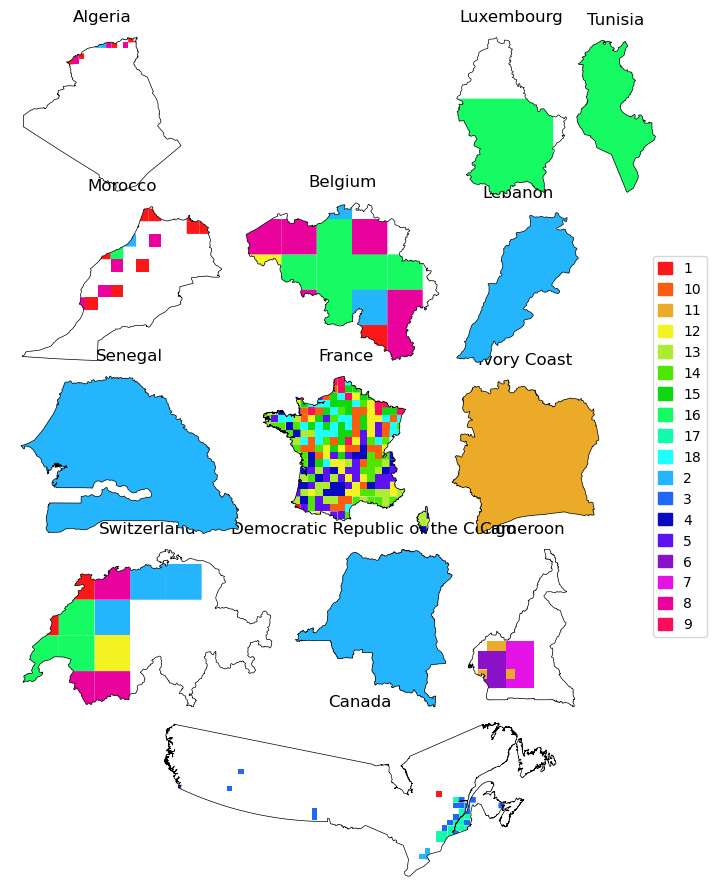

In [618]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, levels_subset=[0,1,2])

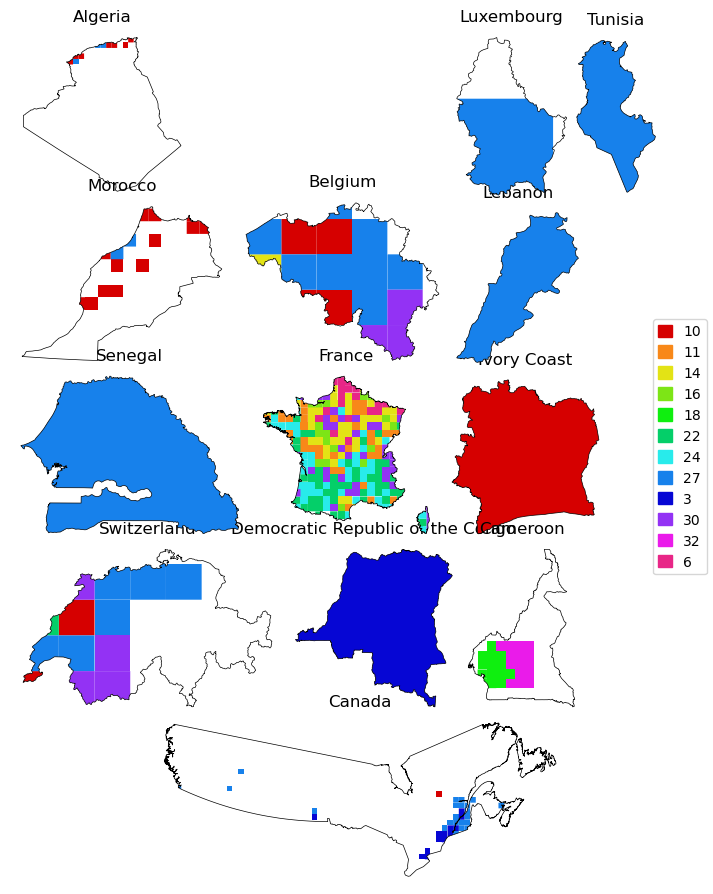

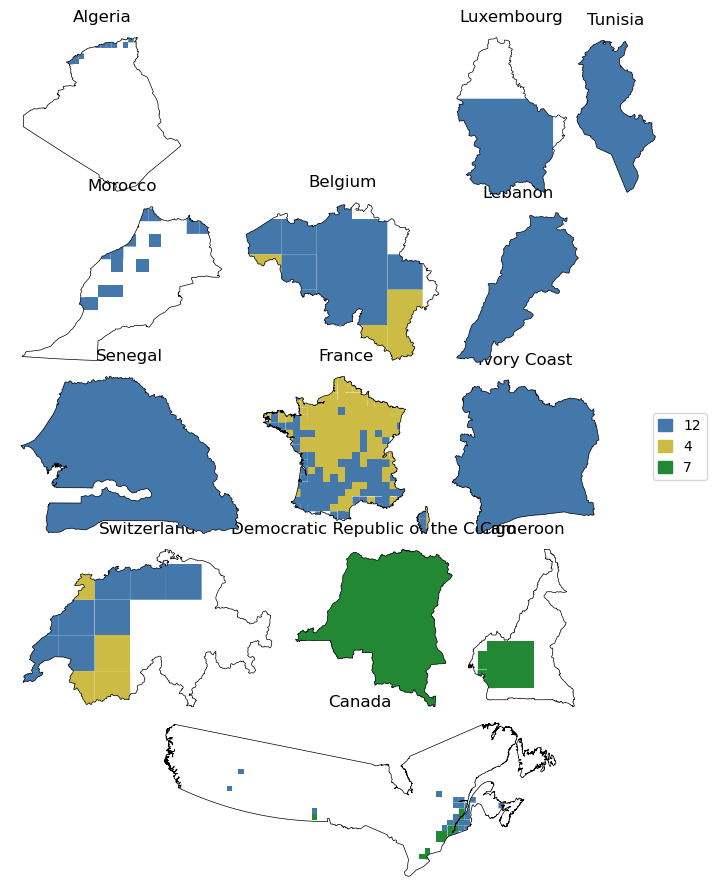

In [208]:
fig, axes = lang.map_clustering(i_decompo=-1, i_clust=-1, levels_subset=[1,2])

In [234]:
clust_words = lang.get_clust_words(i_clust=-1, i_lvl=2)
clust_words.head()

,count,is_proper,nr_cells,cell_counts_mask,is_regional,cluster1,cluster4,cluster5,dist1,dist4,dist5
word,,,,,,,,,,,
de,48104083.0,0.0,1910.659356,True,True,-1.400541,0.257062,-0.700070,0.490660,0.916101,0.490660
la,30264945.0,0.0,1909.211037,True,True,-1.366849,-0.222709,-0.869228,0.247626,0.417986,0.247626
est,29471290.0,0.0,1904.214246,True,True,-0.649811,-0.924878,-0.606810,0.001849,0.075662,0.001849
le,26725117.0,0.0,1905.577297,True,True,-1.430624,-0.067248,-0.875976,0.307634,0.654040,0.307634
je,24467287.0,0.0,1902.653273,True,True,0.988895,-0.866202,0.293035,0.484221,1.343830,0.484221


In [238]:
clust_nr = 5
coord_col = f'cluster{clust_nr}'
dist_col = f'dist{clust_nr}'
clust_words[f'spec{clust_nr}'] = clust_words[dist_col] #* np.log(clust_words['count'])
# without coord > 0 filter, as south cluster is strongest,  others are thus
# first characterised as not having this cluster's words. Hence the need to
# filter.
top_clust_words = clust_words.sort_values(
    by=f'spec{clust_nr}', key=np.abs, ascending=False
)[['count', coord_col, dist_col]]
top_clust_words.loc[clust_words[coord_col] > 0].head(20)

,count,cluster5,dist5
word,,,
aller,1345034.0,0.000945,0.928316
mon,6719900.0,0.018347,0.893680
lit,313239.0,0.282047,0.874144
dormir,508441.0,0.059248,0.869079
réveiller,157699.0,0.163501,0.858748
demain,1727030.0,0.154098,0.830411
mal,1315827.0,0.090388,0.823352
mère,837129.0,0.124681,0.806951
dormi,99861.0,0.074602,0.780236


## Try to get edge covariate fit....

In [251]:
gt.PropertyArray(4., None)

PropertyArray(4.)

In [253]:
g = gt.collection.ns["train_terrorists"]
state = gt.minimize_nested_blockmodel_dl(
    g,
    state_args={
        'recs': [g.ep.weight],
        'rec_types': ["discrete-binomial"],
        'rec_params': [{'N': gt.PropertyArray(4., None), 'alpha': gt.PropertyArray(1., None), 'beta': gt.PropertyArray(1., None)}]
    }
)
for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (2,)

In [188]:
s = state.get_levels()[0]

In [248]:
l = s.get_rec_params()[0]['N']

In [240]:
s.get_rec_params()

[{'N': PropertyArray(4.), 'alpha': nan, 'beta': nan}]

In [200]:
ep = G.ep['weight']

In [201]:
ep.get_array()

PropertyArray([1.07435115, 0.36329882, 0.24057318, ..., 0.69162925,
               0.89906916, 0.45039655])

In [172]:
state.state_args

{'recs': [<EdgePropertyMap object with value type 'int16_t', for Graph 0x7f64d36aa1a0, at 0x7f64d36aae90>],
 'rec_types': ['discrete-binomial'],
 'Lrecdx': array([1., 0., 0.]),
 'rec_params': ['microcanonical']}

In [167]:
res.state_args

{'recs': [<EdgePropertyMap object with value type 'double', for Graph 0x7f64f17b4220, at 0x7f66de673cd0>,
  <EdgePropertyMap object with value type 'double', for Graph 0x7f64f17b4220, at 0x7f66de673790>],
 'rec_types': array([1, 3], dtype=int32),
 'Lrecdx': array([4.00000000e+00, 0.00000000e+00, 8.28252273e+07]),
 'rec_params': [{}, {'m0': nan, 'k0': nan, 'v0': nan, 'nu0': nan}],
 'eweight': <EdgePropertyMap object with value type 'int32_t', for Graph 0x7f64f17b4220, at 0x7f66de673e20>,
 'vweight': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f64f17b4220, at 0x7f66de673ac0>,
 'B': 386,
 'clabel': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f64f17b4220, at 0x7f66de673b80>,
 'pclabel': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f64f17b4220, at 0x7f66de672710>,
 'bfield': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f64f17b4220, at 0x7f66de673820>,
 'deg_corr': True,
 'dense_bg': False}

In [159]:
eweight = res.state_args['recs'][1]

In [179]:
np.asarray(eweight.get_array())

array([1.07435115, 0.36329882, 0.24057318, ..., 0.69162925, 0.89906916,
       0.45039655])

In [ ]:
dist_vec = scipy.spatial.distance.pdist(decomp.proj_vectors, metric='correlation')

In [ ]:
G.edge

Get marginals / fuzzy clusters

In [ ]:
# # We will first equilibrate the Markov chain
# gt.mcmc_equilibrate(res, wait=1000, mcmc_args=dict(niter=10))
# collect nested partitions
bs = []
def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
gt.mcmc_equilibrate(res, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)
# Disambiguate partitions and obtain marginals
pmode = gt.PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g)

# Get consensus estimate
bs = pmode.get_max_nested()

In [ ]:
ray.shutdown()

# Overlap between clusterings

In [ ]:
import sklearn.metrics
import clusim.clustering
import clusim.sim

In [ ]:
lang = eng_all

In [ ]:
lang.decompositions[-1].clusterings[0].levels[1]

In [ ]:
_ = lang.map_clustering(i_clust=2)

In [ ]:
_ = lang.map_clustering(i_clust=-4)

In [ ]:
lang.decompositions[-1].clusterings[-1].levels[0].cell_dict

In [ ]:
c1 = clusim.clustering.Clustering().from_elm2clu_dict(lang.decompositions[-1].clusterings[-4].cell_dict)
c2 = clusim.clustering.Clustering().from_elm2clu_dict(lang.decompositions[-1].clusterings[0].levels[1].cell_dict)

In [ ]:
clusts = lang.decompositions[-1].clusterings
c1 = clusim.clustering.Clustering().from_elm2clu_dict({
    key: value for key, value in zip(cells_ids, clusts[-4].labels.values)
})
c2 = clusim.clustering.Clustering().from_elm2clu_dict({
    key: value for key, value in zip(cells_ids, clusts[2].levels[0].labels.values)
})

In [ ]:
ecs = clusim.sim.element_sim(c1, c2, alpha=0.9)
ecs

In [ ]:
clusim.sim.vi(c1, c2, norm_type='entropy')

In [ ]:
clusim.sim.rmi(c1, c2, norm_type='normalized')

In [ ]:
clust1_labels = clusts[-1].labels.values.astype(int)
clust2_labels = clusts[0].levels[1].labels.values.astype(int)

print(sklearn.metrics.adjusted_mutual_info_score(clust1_labels, clust2_labels),
      sklearn.metrics.adjusted_rand_score(clust1_labels, clust2_labels),
      sklearn.metrics.rand_score(clust1_labels, clust2_labels))

In [ ]:
m1 = clusts[-1].get_binary_matrix()
m2 = clusts[0].levels[1].get_binary_matrix(other_matrix=m1)

In [ ]:
print(
    sklearn.metrics.jaccard_score(m1, m2, average='weighted'),
    sklearn.metrics.jaccard_score(m1, m2, average='samples'))

In [ ]:
sklearn.metrics.jaccard_score(m1, m2, average='micro')

# Get words characteristic of each cluster

In [ ]:
import sklearn.metrics

In [ ]:
decomp = lang.decompositions[-1]
clust = decomp.clusterings[-1]

In [ ]:
clust_words = lang.get_clust_words(i_clust=-1, i_lvl=4)

In [ ]:
clust_words.columns

In [ ]:
clust_nr = 1
col = f'cluster{clust_nr}'
clust_words.loc[clust_words[col] > 0].sort_values(
    by=f'dist{clust_nr}', key=np.abs, ascending=False)[['count', col, f'dist{clust_nr}']].head(40)
# clust_words.head(20)

In [ ]:
clust_nr = 3
coord_col = f'cluster{clust_nr}'
dist_col = f'dist{clust_nr}'
clust_words[f'spec{clust_nr}'] = clust_words[dist_col] * np.log(clust_words['count'])
clust_words.loc[clust_words[coord_col] > 0].sort_values(
    by=f'spec{clust_nr}', key=np.abs, ascending=False)[['count', coord_col, dist_col]].head(20)

In [ ]:
median_dist = clust_words.loc[clust_words[col] > 0][f'dist{clust_nr}'].median()
mask = (clust_words[col] > 0) & (clust_words[f'dist{clust_nr}'] > median_dist)
clust_words.loc[mask].sort_values(
    by='count', ascending=False).head(20)

# Plot words

In [ ]:
fig, axes = lang.map_word('know')

In [ ]:
fig, axes = lang.map_word('wanna')

In [ ]:
fig, axes = lang.map_word('wanna')

In [ ]:
fig, axes = lang.map_word('brun')

In [ ]:
fig, axes = lang.map_word('innings')

In [ ]:
fig, axes = lang.map_word('tym')

In [ ]:
idx_word = lang.global_counts.index.get_loc('reports')
z_plot = (lang.word_counts_vectors.T / lang.word_counts_vectors.sum(axis=1)).T[:, idx_word]
# z_plot = (z_plot > 0).astype(int)
fig, axes = lang.map_continuous_choro(np.log10(z_plot))